In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy import signal
from scipy.integrate import simps
from collections import OrderedDict

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.neural_network import MLPClassifier

4 EEG leads collected at 200 Hz for approximately three minutes while the subject was (1) listening to music, and (2) reading.  

https://www.kaggle.com/millerintllc/eeg-microexperiment

In [84]:
# import data
path = 'eeg-microexperiment/'
music = 'tiny_eeg_self_experiment_music.csv'
reading = 'tiny_eeg_self_experiment_reading.csv'

df_music = pd.read_csv(path+music)
df_reading = pd.read_csv(path+reading)

df_music_train = df_music.iloc[:37000]
df_music_test = df_music.iloc[37000:]
df_reading_train = df_reading.iloc[:37000]
df_reading_test = df_reading.iloc[37000:]

In [85]:
len(df_music), len(df_reading)

(39647, 38256)

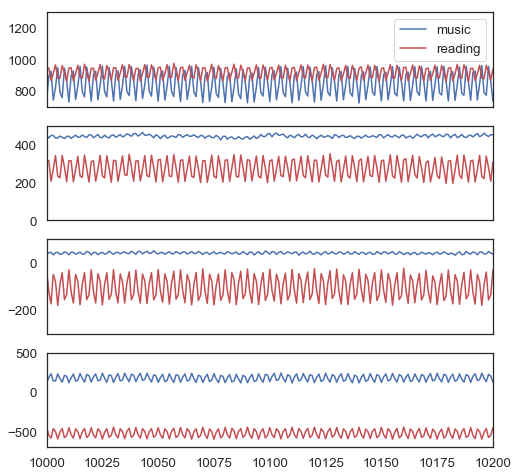

In [185]:
# quick peak at what the data looks like 
start = 10000
fig, ax = plt.subplots(ncols = 1, nrows = 4, figsize = [8, 8])

for ik, label in enumerate(['Channel1', 'Channel2', 'Channel3', 'Channel4']):
    ax[ik].plot([ik for ik in range(min(len(df_reading), len(df_music)))], df_music[label][0:min(len(df_reading), len(df_music))], color = 'b', label = 'music')
    ax[ik].plot([ik for ik in range(min(len(df_reading), len(df_music)))], df_reading[label][0:min(len(df_reading), len(df_music))], color = 'r', label = 'reading')
    ax[ik].set_xlim([start, start+200])
    
ax[0].set_ylim([700, 1300])
ax[1].set_ylim([0, 500])
ax[2].set_ylim([-300, 100])
ax[3].set_ylim([-700, 500])

ax[0].legend()

for ip in range(3):
    ax[ip].set_xticklabels([])

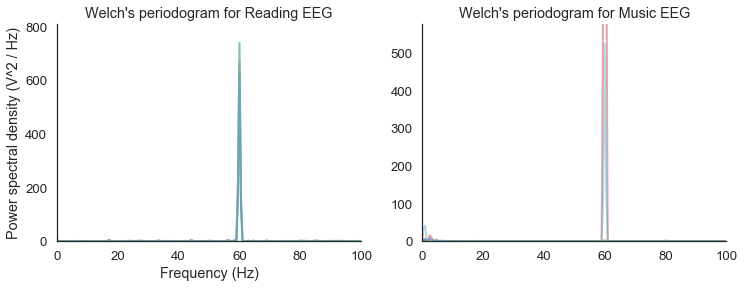

In [190]:
# plot power spectral density for each channel of each activity EEG leads

win = 2 * sf
sf = 200 #sampling frequency
channel_d = OrderedDict({'Channel1':'r', 'Channel2':'b', 'Channel3':'g', 'Channel4':'c'})

fig, ax = plt.subplots(nrows =1, ncols = 2, figsize = [12,4])
activities_d = {'Reading':df_reading, 'Music':df_music}

for ind, act in enumerate(activities_d.keys()):
    for num, channel in enumerate(channel_d.keys()):
        freqs, psd = signal.welch(activities_d[act][channel].iloc[ik:ik+win], sf, nperseg=win)
        ax[ind].plot(freqs, psd, color=channel_d[channel], lw=2, alpha = .5)
        ax[0].set_xlabel('Frequency (Hz)')
        ax[0].set_ylabel('Power spectral density (V^2 / Hz)')
        ax[ind].set_ylim([0, psd.max() * 1.1])
        ax[ind].set_title("Welch's periodogram for " + act + " EEG" )
        ax[ind].set_xlim([0, freqs.max()])
    sns.despine()


In [167]:
# building the feature set where each row has PSD data for each of five bands for each of four leads and an activity label

bands_d = OrderedDict({'delta': (.5, 4),'theta': (4, 8),'alpha': (8, 12),'beta': (12, 30),'gamma': (30, 100)})
channel_d = OrderedDict({'Channel1':'r', 'Channel2':'b', 'Channel3':'g', 'Channel4':'c'})

# Define window length (4 seconds)
win = 2 * sf

def make_data_d():
    return {'label':[], 
              'delta1':[], 'delta2':[], 'delta3':[], 'delta4':[],
             'theta1':[], 'theta2':[], 'theta3':[], 'theta4':[],
             'alpha1':[], 'alpha2':[], 'alpha3':[], 'alpha4':[],
             'beta1':[], 'beta2':[], 'beta3':[], 'beta4':[],
             'gamma1':[], 'gamma2':[], 'gamma3':[], 'gamma4':[]}


def make_eeg_feat(label, df_act, data_d):
    nrows = len(range(0, int((np.floor(len(df_act)/win)-1)*win), win))

    for ik in range(0, int((np.floor(len(df_act)/win)-1)*win), win):
        for num, channel in enumerate(channel_d.keys()):
            freqs, psd = signal.welch(df_act[channel].iloc[ik:ik+win], sf, nperseg=win)
            freq_res = freqs[1] - freqs[0]
            for band, bounds in bands_d.items():
                idx = np.logical_and(freqs >= bounds[0], freqs <= bounds[1])
                power = simps(psd[idx], dx=freq_res)
                data_d[band+str(num+1)].append(power)
        data_d['label'].append(label)
    
    return data_d

#N.B. Relative delta power (expressed as a percentage of total power)
# total_power = simps(psd, dx=freq_res)
# delta_rel_power = delta_power / total_power
# print('Relative delta power: %.3f' % delta_rel_power)


In [168]:
def make_feat_target(d):
    df = pd.DataFrame(d)
    X = df.iloc[:, ~df.columns.isin(['label'])]
    y = df['label']
    return X, y

In [169]:
train_d = make_data_d()
train_d = make_eeg_feat('music', df_music_train, train_d)
train_d = make_eeg_feat('reading', df_reading_train, train_d)
X_train, y_train = make_feat_target(train_d)

test_d = make_data_d()
test_d = make_eeg_feat('music', df_music_test, test_d)
test_d = make_eeg_feat('reading', df_reading_test, test_d)
X_test, y_test = make_feat_target(test_d)

In [180]:
# train the model
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(60,))
mlp.fit(X_train, y_train)

mlp.score(X_test, y_test)


1.0

In [186]:
# Try some other models
from sklearn.linear_model import SGDClassifier

gdclf = SGDClassifier()

gdclf.fit(X_train, y_train)
gdclf.score(X_test, y_test)


/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


1.0

As it turns out, the data was too clean, so there is relatively little to hone with parameters.  Some probing suggests that performance improves as the number of nodes in the hidden layer increases to ~60, but beyond that I did not investigate the parameter space.  